In [4]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from utils.surround_view import convert_bird_eye_view, blend_bird_eye_img, top_img_to_bird_eye_view_cuda, bottom_img_to_bird_eye_view_cuda, left_img_to_bird_eye_view_cuda, right_img_to_bird_eye_view_cuda

In [2]:
print(cv2.getBuildInformation())


General configuration for OpenCV 4.10.0 =====================================
  Version control:               4.10.0

  Platform:
    Timestamp:                   2024-06-17T17:58:36Z
    Host:                        Windows 10.0.17763 AMD64
    CMake:                       3.24.2
    CMake generator:             Visual Studio 14 2015
    CMake build tool:            MSBuild.exe
    MSVC:                        1900
    Configuration:               Debug Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (0 files):            + SSSE3 SSE4_1 POPCNT SSE4_2 FP16 AVX
      AVX (8 files):             + SSSE3 SSE4_1 POPCNT SSE4_2 AVX
      AVX2 (36 files):           + SSSE3 SSE4_

In [9]:
front_img = cv2.imread(os.path.join('save_img', 'front_img.jpg'))
front_img = cv2.cvtColor(front_img, cv2.COLOR_RGB2BGR)

left_img = cv2.imread(os.path.join('save_img', 'left_img.jpg'))
left_img = cv2.cvtColor(left_img, cv2.COLOR_RGB2BGR)

right_img = cv2.imread(os.path.join('save_img', 'right_img.jpg'))
right_img = cv2.cvtColor(right_img, cv2.COLOR_RGB2BGR)

rear_img = cv2.imread(os.path.join('save_img', 'rear_img.jpg'))
rear_img = cv2.cvtColor(rear_img, cv2.COLOR_RGB2BGR)

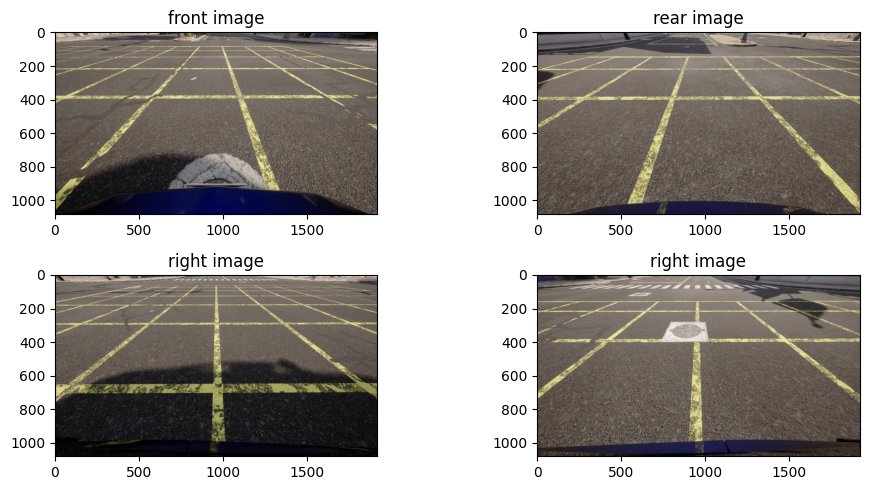

In [10]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 5)

axis[0, 0].imshow(front_img)
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_img)
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_img)
axis[1, 0].set_title('right image')

axis[1, 1].imshow(right_img)
axis[1, 1].set_title('right image')

plt.tight_layout()

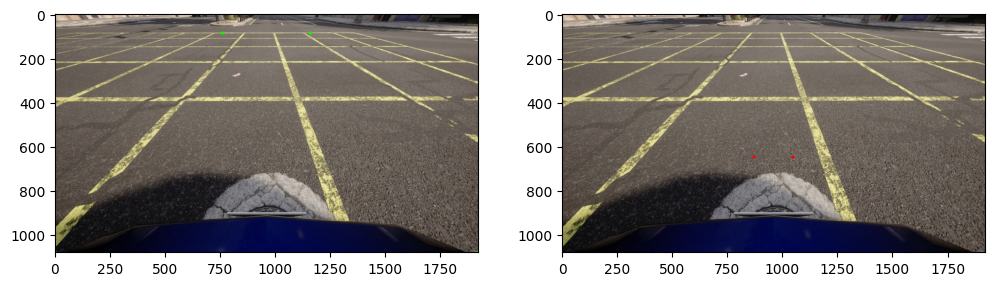

In [11]:
h, w, c = front_img.shape

src_h_ratio = 0.08
src_w_ratio_offset = 0.104

dst_h_ratio = 0.6
dst_w_ratio = 0.0463

src_pts = np.array([[w * (0.5-src_w_ratio_offset), h * src_h_ratio], [w * (0.5+src_w_ratio_offset), h * src_h_ratio], [w, h], [0, h]], dtype=np.float32)
dst_pts = np.array([[w*0.4, 0], [w*0.6, 0], [w*(0.5+dst_w_ratio), h*dst_h_ratio], [w*(0.5-dst_w_ratio), h*dst_h_ratio]], dtype=np.float32)

front_img_copy_1 = front_img.copy()
front_img_copy_2 = front_img.copy()

for pos in src_pts:
    pos = pos.astype(np.int32)
    cv2.circle(img=front_img_copy_1, center=pos, radius=2, color=(0, 255, 0), thickness=10)

for pos in dst_pts:
    pos = pos.astype(np.int32)
    cv2.circle(img=front_img_copy_2, center=pos, radius=2, color=(255, 0, 0), thickness=10)

fig, axis = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
axis[0].imshow(front_img_copy_1)
axis[1].imshow(front_img_copy_2)

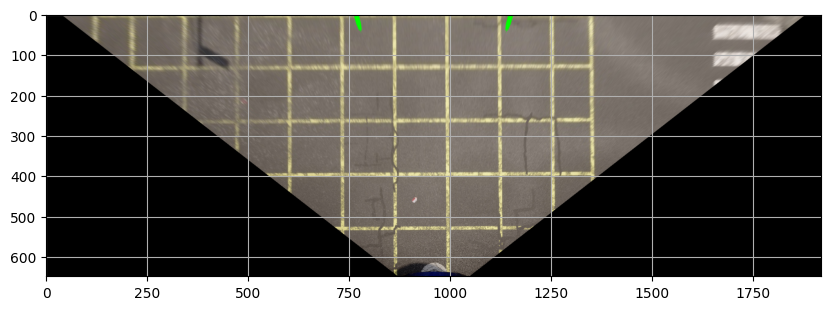

In [12]:
m = cv2.getPerspectiveTransform(src_pts, dst_pts)
dst_img = cv2.warpPerspective(src=front_img_copy_1, M=m, dsize=(w, int(h*dst_h_ratio)), flags=cv2.INTER_LINEAR, borderValue=(0, 0, 0))

plt.figure(figsize=(10, 10))
plt.grid()
plt.imshow(dst_img)

In [13]:
front_dst = convert_bird_eye_view(front_img)
left_dst = convert_bird_eye_view(left_img)
right_dst = convert_bird_eye_view(right_img)
rear_dst = convert_bird_eye_view(rear_img)

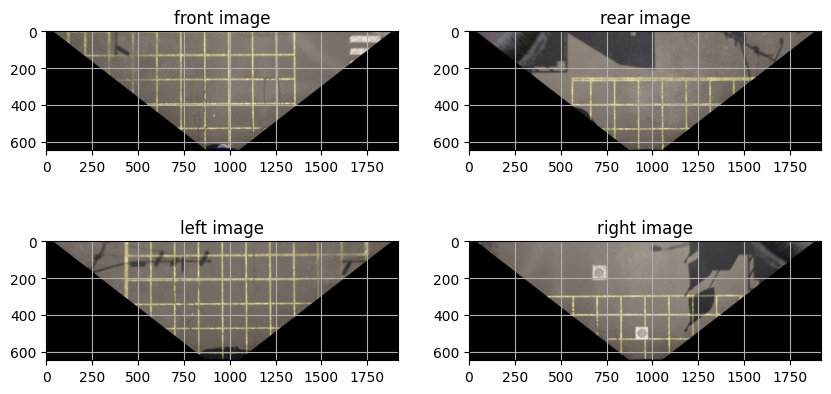

In [14]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 5)

axis[0, 0].imshow(front_dst)
axis[0, 0].grid()
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_dst)
axis[0, 1].grid()
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_dst)
axis[1, 0].grid()
axis[1, 0].set_title('left image')

axis[1, 1].imshow(right_dst)
axis[1, 1].grid()
axis[1, 1].set_title('right image')

dst_img_list = [front_dst, rear_dst, left_dst, right_dst]
dst_img_name_list =['front_dst.jpg', 'rear_dst.jpg','left_dst.jpg', 'right_dst.jpg']

for img_name, img in zip(dst_img_name_list, dst_img_list):
    cv2.imwrite(os.path.join('save_img', img_name), cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [15]:
for i in range(30):
    front_dst = convert_bird_eye_view(front_img)
    left_dst = convert_bird_eye_view(left_img)
    right_dst = convert_bird_eye_view(right_img)
    rear_dst = convert_bird_eye_view(rear_img)

    left_img_rot = cv2.rotate(left_dst, cv2.ROTATE_90_COUNTERCLOCKWISE)
    right_img_rot = cv2.rotate(right_dst, cv2.ROTATE_90_CLOCKWISE)
    rear_img_rot = cv2.rotate(rear_dst, cv2.ROTATE_180)

    result = blend_bird_eye_img(front_dst, left_dst, right_dst, rear_dst)


Text(0.5, 1.0, 'right image')

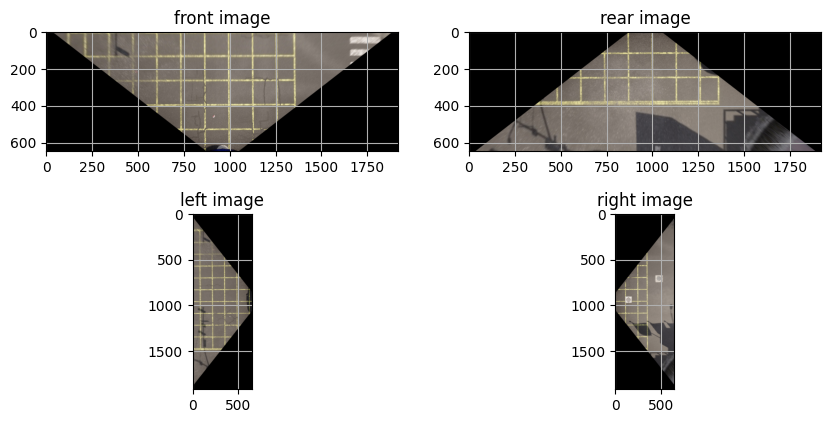

In [17]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 5)

axis[0, 0].imshow(front_dst)
axis[0, 0].grid()
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_img_rot)
axis[0, 1].grid()
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_img_rot)
axis[1, 0].grid()
axis[1, 0].set_title('left image')

axis[1, 1].imshow(right_img_rot)
axis[1, 1].grid()
axis[1, 1].set_title('right image')

In [18]:
front_img_top_offset = 170
left_img_left_offset = 260
right_img_right_offset = 260

border_color = (0, 0, 0)

front_ext = cv2.copyMakeBorder(front_dst, front_img_top_offset, 1920-(front_dst.shape[0]+front_img_top_offset), 0, 0,
                               cv2.BORDER_CONSTANT, value=border_color)

rear_ext = cv2.copyMakeBorder(rear_img_rot, 1920-(rear_dst.shape[0]+front_img_top_offset), front_img_top_offset, 0, 0,
                              cv2.BORDER_CONSTANT, value=border_color)

left_ext = cv2.copyMakeBorder(left_img_rot, 0, 0, left_img_left_offset, 1920-(left_img_rot.shape[1]+left_img_left_offset),
                               cv2.BORDER_CONSTANT, value=border_color)

right_ext = cv2.copyMakeBorder(right_img_rot, 0, 0, 1920-(right_img_rot.shape[1]+right_img_right_offset), right_img_right_offset,
                               cv2.BORDER_CONSTANT, value=border_color)

Text(0.5, 1.0, 'right image')

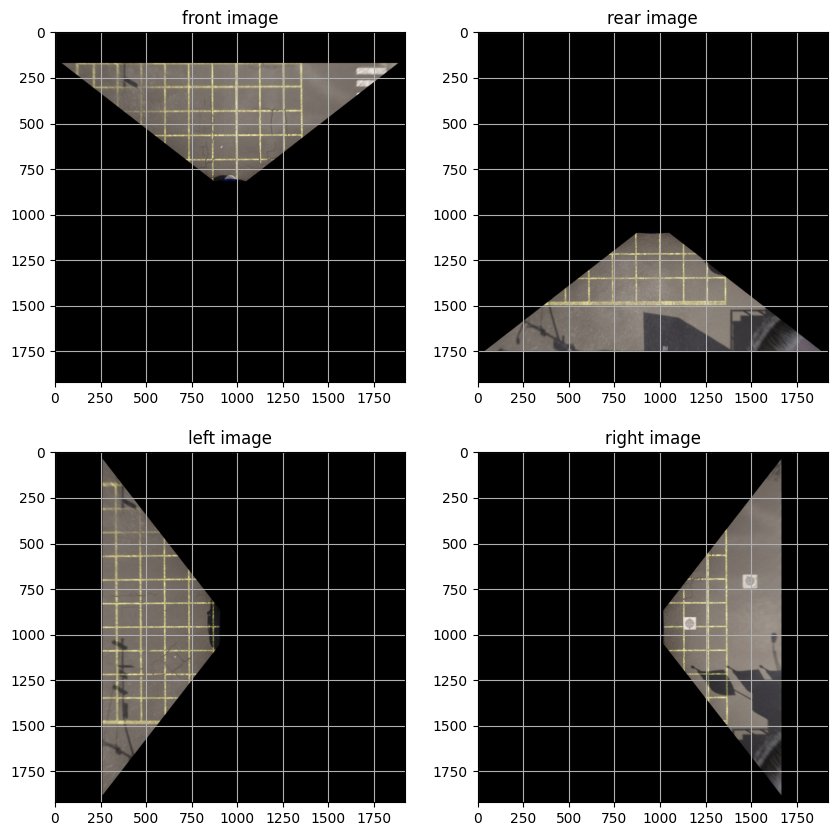

In [19]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)

axis[0, 0].imshow(front_ext)
axis[0, 0].grid()
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_ext)
axis[0, 1].grid()
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_ext)
axis[1, 0].grid()
axis[1, 0].set_title('left image')

axis[1, 1].imshow(right_ext)
axis[1, 1].grid()
axis[1, 1].set_title('right image')

In [27]:
gray = cv2.cvtColor(front_ext, cv2.COLOR_BGR2GRAY)
_, front_img_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

gray = cv2.cvtColor(rear_ext, cv2.COLOR_BGR2GRAY)
_, rear_img_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

gray = cv2.cvtColor(left_ext, cv2.COLOR_BGR2GRAY)
_, left_img_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

gray = cv2.cvtColor(right_ext, cv2.COLOR_BGR2GRAY)
_, right_img_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

Text(0.5, 1.0, 'right image')

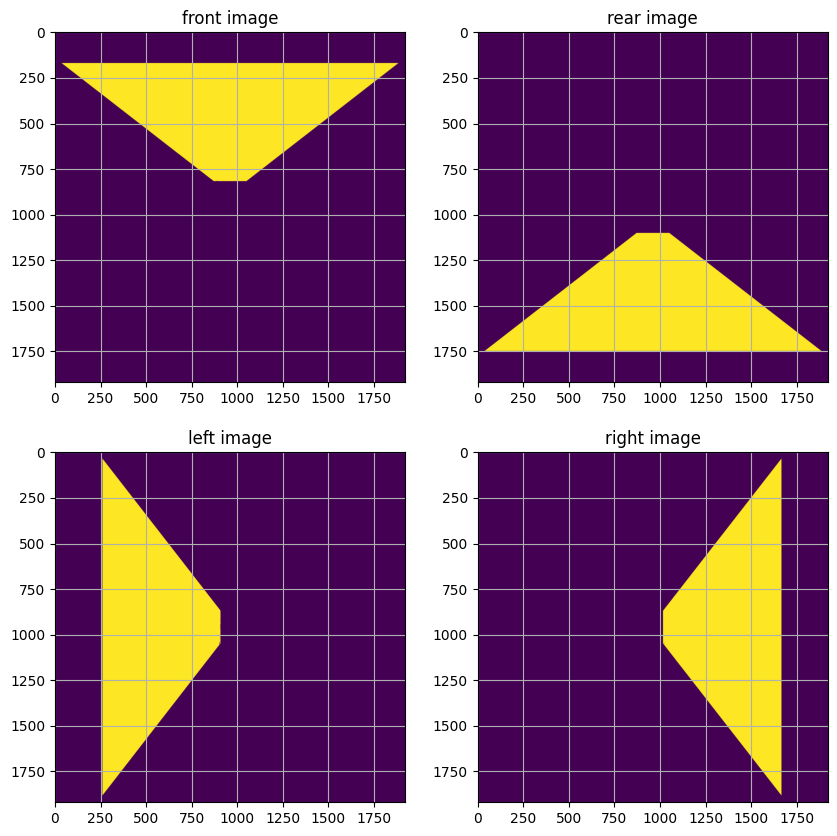

In [28]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)

axis[0, 0].imshow(front_img_mask)
axis[0, 0].grid()
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_img_mask)
axis[0, 1].grid()
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_img_mask)
axis[1, 0].grid()
axis[1, 0].set_title('left image')

axis[1, 1].imshow(right_img_mask)
axis[1, 1].grid()
axis[1, 1].set_title('right image')

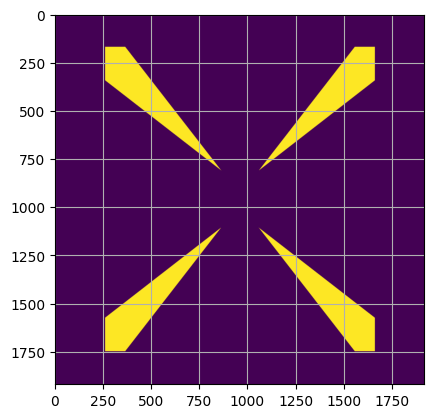

In [38]:
a = np.bitwise_and(front_img_mask, left_img_mask)
b = np.bitwise_and(front_img_mask, right_img_mask)
c = np.bitwise_and(rear_img_mask, left_img_mask)
d = np.bitwise_and(rear_img_mask, right_img_mask)

e = a+b+c+d

plt.imshow(e)
plt.grid(True)

In [39]:
front_ext[e==255] = (0, 0, 0)
rear_ext[e==255] = (0, 0, 0)

Text(0.5, 1.0, 'front image')

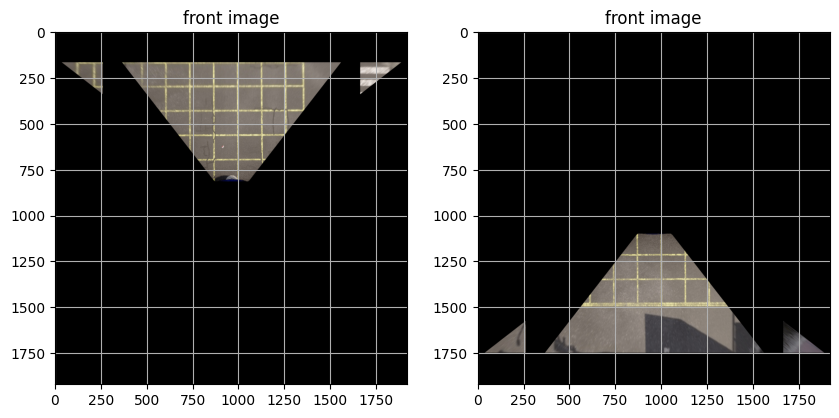

In [45]:
fig, axis = plt.subplots(ncols=2)
fig.set_size_inches(10, 10)

axis[0].imshow(front_ext)
axis[0].grid()
axis[0].set_title('front image')

axis[1].imshow(rear_ext)
axis[1].grid()
axis[1].set_title('front image')


In [51]:
result = np.empty(shape=(1920, 1920, 3), dtype=np.uint8)
result[:] = front_ext+rear_ext+left_ext+right_ext

(1920, 1920, 3)


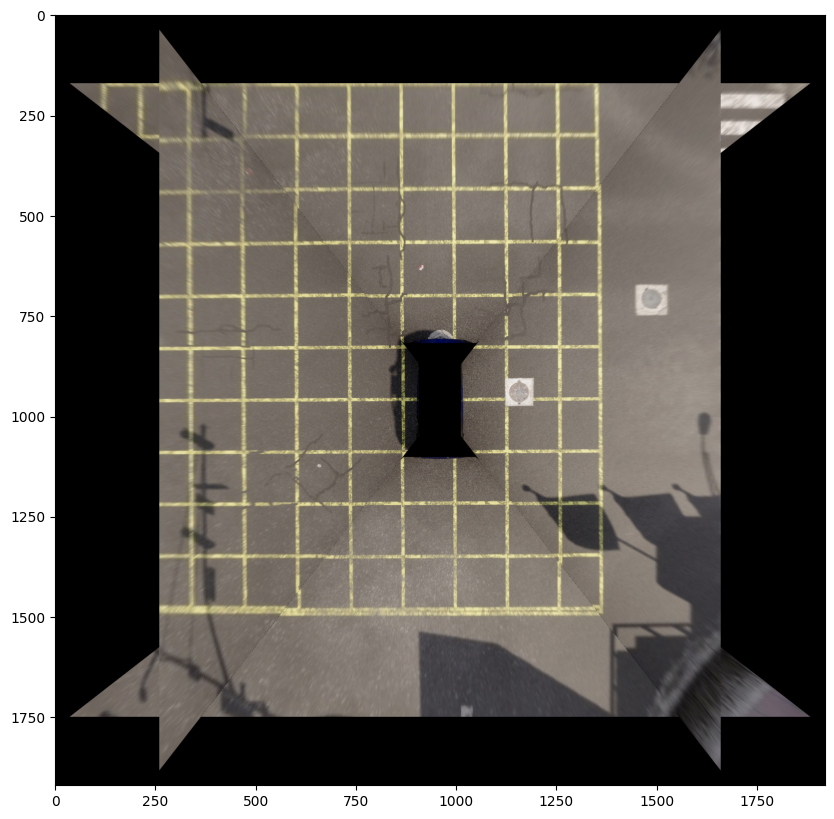

In [52]:
plt.figure(figsize=(10, 10))

plt.imshow(result)

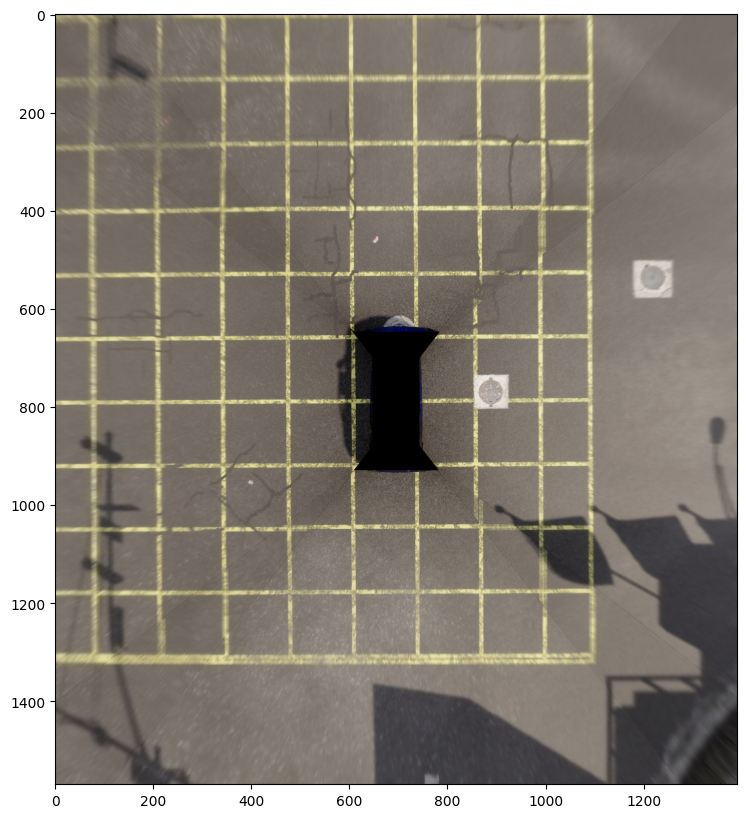

In [81]:
result_1 = result[170:1740, 350:1740]

plt.figure(figsize=(10, 10))
plt.imshow(result_1)